# divide observations into watermasses based on location

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

# for cutting off 1000 km from shore
from functools import lru_cache
from pyproj import Geod
from scipy.spatial import cKDTree
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon, MultiPolygon

import warnings
warnings.filterwarnings("ignore")

In [3]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/grid.nc')
obs = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/observations/PNW_obs_compiled.csv')

## remove unnecessary points

In [4]:
len(obs)

2340133

In [5]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [6]:
len(obs)

1297895

In [7]:
# depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [8]:
len(obs)

1192356

In [9]:
#boolean for being within 1000 km from the shore. 

# --- helpers ---
def _lonlat_to_unit(lon_deg, lat_deg):
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(lat_deg)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return np.column_stack((x, y, z))

@lru_cache(maxsize=1)
def _coast_vertices(scale='110m'):
    """
    Return coastline vertices (lon, lat) from Natural Earth 'land' at chosen scale.
    scale: '110m'|'50m'|'10m'  (finer -> more vertices -> slower to build)
    """
    path = shpreader.natural_earth(resolution=scale, category='physical', name='land')
    reader = shpreader.Reader(path)
    lons, lats = [], []
    for rec in reader.records():
        geom = rec.geometry
        if isinstance(geom, Polygon):
            xs, ys = geom.exterior.xy
            lons.extend(xs); lats.extend(ys)
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                xs, ys = poly.exterior.xy
                lons.extend(xs); lats.extend(ys)
    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # normalize longitudes to [-180, 180] for consistency
    lons = ((lons + 180) % 360) - 180
    return lons, lats

@lru_cache(maxsize=1)
def _coast_kdtree(scale='110m'):
    coast_lon, coast_lat = _coast_vertices(scale)
    xyz = _lonlat_to_unit(coast_lon, coast_lat)
    tree = cKDTree(xyz)
    return tree, coast_lon, coast_lat

def add_within_coast_boolean(obs, lon_col="longitude (degrees_east)", lat_col="latitude (degrees_north)",
                             max_km=1000.0, scale='110m', chunk=200_000):
    """
    Add boolean column 'within_1000km_coast' to obs, True if nearest land vertex <= max_km.
    Uses Natural Earth land polygons at 'scale'.
    """
    # pull data
    lons = np.asarray(obs[lon_col], dtype=float)
    lats = np.asarray(obs[lat_col], dtype=float)
    # normalize longitudes to [-180,180]
    lons = ((lons + 180) % 360) - 180

    valid = np.isfinite(lons) & np.isfinite(lats)
    out = np.zeros(len(obs), dtype=bool)

    geod = Geod(ellps='WGS84')
    tree, coast_lon, coast_lat = _coast_kdtree(scale)

    idx = np.flatnonzero(valid)
    for start in range(0, idx.size, chunk):
        sel = idx[start:start+chunk]
        pts_xyz = _lonlat_to_unit(lons[sel], lats[sel])
        # nearest coastline vertex (in 3D unit sphere)
        _, nn_idx = tree.query(pts_xyz, k=1, workers=-1)
        nn_lon = coast_lon[nn_idx]
        nn_lat = coast_lat[nn_idx]
        # precise geodesic distance to nearest vertex (meters)
        _, _, d_m = geod.inv(lons[sel], lats[sel], nn_lon, nn_lat)
        out[sel] = d_m <= (max_km * 1000.0)

    return out

boo = add_within_coast_boolean(obs)
obs = obs[boo]

In [10]:
len(obs)

1188828

In [11]:
# lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [40, 50.8]

obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [12]:
len(obs)

1045650

In [13]:
# and honestly i really dont think the washington ecology data or onc data are useful for my purposes
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [14]:
len(obs)

883404

## unit conversion
originally went with the most common choice from observations, but there are some better choices for the sake of the paper

In [15]:
# convert Nstar from umol/kg to mmol/m3 (uM)

# Calculate seawater density using TEOS-10
conservative_temp = gsw.CT_from_t(obs['salinity (g kg-1)'], obs['temperature (degC)'], obs['pressure (dbar)'])
density_seawater = gsw.rho(obs['salinity (g kg-1)'], conservative_temp, obs['pressure (dbar)'])  # Density in kg/m^3
    
# Convert µmol/kg to µmol/L (µM=mmol/m3) using the seawater density
newNstar = obs['Nstar (umol kg-1)'] * (density_seawater / 1000)
obs['Nstar (uM)'] = newNstar

In [16]:
# convert TA, DIC, carbonate from mmol/m3 to umol/kg
    
# Convert µmol/L to µmol/kg using the seawater density
newTA = (obs['TA (uM)'] / density_seawater) * 1000
newDIC = (obs['DIC (uM)'] / density_seawater) * 1000
newCarb = (obs['Carbonate'] / density_seawater) * 1000

obs['TA (umol/kg)'] = newTA
obs['DIC (umol/kg)'] = newDIC
obs['Carbonate (umol/kg)'] = newCarb
    

## dividing based on bathymetry

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

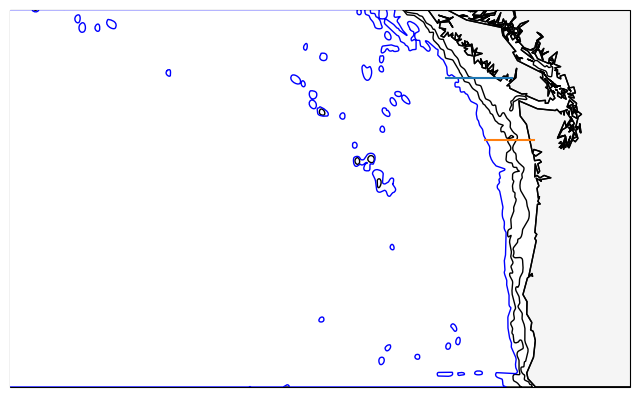

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [18]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.unary_union)

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [19]:
# can we do the same for data between the 200 m and 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.unary_union)

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

In [20]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

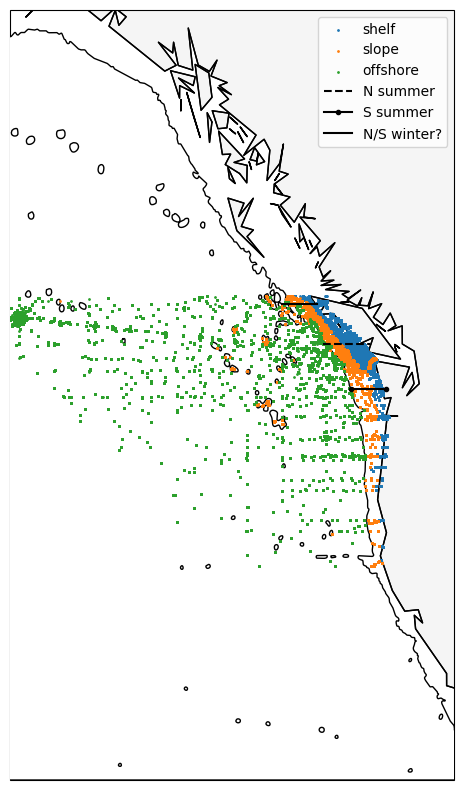

In [21]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()


In [22]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [23]:
# save  obs file with all the data you don't need removed and the location and month columns added
obs.to_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/observations/filtered_obs.csv')